Launch Trajectory
---

In [127]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

The game will have a current state. Rocket location (2), direction (1), velocity (2), air density (1), fuel remaining (1). 7 total state parameters.

The rocket wants to minimize vertical speed at the end, approach a certain horizontal speed, maximize leftover fuel.

In [128]:
target_velocity = [30000., 0.] #m/s
target_altitude = 500000. #m
isp = 500. #s
g = 9.81 #m/s

What do I want to get done today?

Make a policy model that tells whether to fire, torque l, or torque r at any time.

In [374]:
#create a rocket ready to launch.
class rocket:
    def __init__(self,
                 g = 9.81,
                 dry_mass = 100.,
                 fuel_mass = 100.,
                 isp = 500.,
                 torque_strength = 0.01,
                 time_step = 0.1,
                 drag_coef = 1.,
                 length = 4,
                 max_fuel_rate = 0.1 # per second
                ):
        #keep track of flight time
        self.stopwatch = 0.
        self.time_step = time_step
        self.position = np.array([0.,0.])
        
        #current velocity and pointing direction (not necessarily parallel)
        self.velocity =  np.array([0.,0.])
        self.heading = np.array([0.,1.])
        
        #angular velocity
        self.spin = 0.
        
        #drag
        self.drag_coef = drag_coef
        self.area = 1.
        #the rocket is 4x longer than it is wide, with this ratio being the perpendicular drag to head-on drag.
        self.length = length
        
        #fuel, mass, and efficiency
        self.fuel_rate = max_fuel_rate
        self.fuel_mass = fuel_mass
        self.dry_mass = dry_mass
        self.isp = isp
        self.torque_strength = torque_strength
        
        #gravity
        self.g = np.array([0., -g])
        
        #keep track of trajectory history
        self.position_history = [
            self.position
        ]
        self.velocity_history = [
            self.velocity
        ]
        self.heading_history = [
            self.heading
        ]
    
    #calculate drag area due to not flying directly forward
    def drag_area(self):
        speed = np.linalg.norm(self.velocity)
        dot = np.dot(self.velocity, self.heading)
        if speed > 0. and dot != 0.:
            heading_velocity_angle = np.arccos(dot/(1.*speed)) #heading is always length 1
            this_area = self.area*(1. + np.sin(heading_velocity_angle))
            return this_area
        else:
            return self.area
        
    #adds speed in heading direction and removes fuel
    def fire(self):
        fuel_chunk = self.fuel_rate*self.time_step
        fuel_velocity = self.isp*self.g
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        #remove fuel to fire
        self.fuel_mass -= fuel_chunk
        # change in speed is fuel spent this time step times fuel speed over remaining rocket mass
        dv = fuel_chunk * fuel_velocity / (self.fuel_mass + self.dry_mass)
        # add new speed to the velocity in the direction of heading
        self.velocity += self.heading * dv
    
    #adds rot. velocity and removes fuel
    def torque(self, clockwise = False):
        fuel_chunk = self.fuel_rate*self.time_step
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        torque_direction = 1
        if clockwise:
            torque_direction = -1
        self.spin += self.torque_strength * fuel_chunk * self.time_step * torque_direction
        self.fuel_mass -= fuel_chunk
        
    def is_crashed(self):
        if self.position[1] < 0:
            return True
        else:
            return False
    
    def advance(self):
        #evolve rocket position in direction of velocity
        self.position = self.position + self.velocity*self.time_step
        self.position_history.append(self.position)
        
        #evolve rocket heading according to spin
        rotation_angle = self.spin * self.time_step
        rotation_matrix = np.array(
            [
                [np.cos(rotation_angle),np.sin(rotation_angle)],
                [-np.sin(rotation_angle),np.cos(rotation_angle)]
            ]
        )
        self.heading = self.heading/np.linalg.norm(np.matmul(rotation_matrix , self.heading))
        self.heading_history.append(self.heading)
        
        #evolve rocket velocity in direction of drag + gravity
        drag = 0.5 * self.drag_coef * self.drag_area() * np.linalg.norm(self.velocity) * self.velocity
        self.velocity = self.velocity + self.time_step * (self.g - drag/(self.dry_mass+self.fuel_mass))
        self.velocity_history.append(self.velocity)
        
    def plot_trajectory(self):
        x = np.array(self.position_history)[:,0]
        y = np.array(self.position_history)[:,1]
        plt.scatter(x,y)
        plt.show()

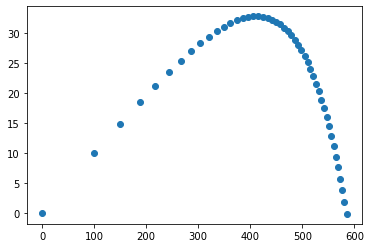

In [375]:
rkt = rocket()
rkt.velocity = np.array([1000.,100.])
for step in range(100):
    rkt.advance()
    if rkt.is_crashed():
        break
rkt.plot_trajectory()

In [376]:
initializer = keras.initializers.he_normal

#make a policy model
class pilot(keras.models.Sequential):
    def __init__(self, num_layers, layer_size):
        super().__init__()
        for layer in range(num_layers):
            self.add(
                keras.layers.Dense(
                                    layer_size,
                                    bias_initializer=initializer,
                                    kernel_initializer=initializer,
                                    activation = 'relu'
                                   )
                    )
        output = keras.layers.Dense(3, activation = 'softmax')
        self.add(output)
        
    def call(self, x, training = True):
        for layer in self.layers:
            x = layer(x, training = training)
        return tf.squeeze(x)

In [377]:
#do the model
target_velocity = tf.constant([27400., 0.], dtype = 'float32') #m/s
target_altitude = tf.constant(200000., dtype = 'float32') #m

In [378]:
trials = 10

pil = pilot(1,64)
f_threshhold = 0.5
l_threshhold = 0.5
r_threshhold = 0.5

loss_fn = tf.losses.Huber()
optimizer = tf.optimizers.Adam(learning_rate=0.001)

for trial in range(trials):
    rkt = rocket()
    with tf.GradientTape() as tape:
        tape.watch(tf.convert_to_tensor(rkt.position))
        tape.watch(tf.convert_to_tensor(rkt.velocity))
        tape.watch(tf.convert_to_tensor(rkt.heading))
        while not rkt.is_crashed():
            inputs = tf.convert_to_tensor(
                [
                rkt.position[0],
                rkt.position[1],
                rkt.velocity[0],
                rkt.velocity[1],
                rkt.heading[0],
                rkt.heading[1]
                ]
            )
            inputs = tf.expand_dims(inputs, 0)
            policy = pil.call(inputs)
            to_fire, to_torque_l, to_torque_r = policy
            if to_fire:
                rkt.fire()
            if to_torque_l:
                rkt.torque()
            elif to_torque_r:
                rkt.torque(clockwise = True)
            rkt.advance()
        loss = tf.abs(rkt.position[1] - target_altitude) + loss_fn(rkt.velocity, target_velocity)
        grads = tape.gradient(loss, pil.trainable_variables)
        optimizer.apply_gradients(zip(grads, pil.trainable_variables))

C:\Users\David\AppData\Local\Temp/ipykernel_6444/2155274665.py:58: RuntimeWarning: invalid value encountered in arccos
  heading_velocity_angle = np.arccos(dot/(1.*speed)) #heading is always length 1


ValueError: No gradients provided for any variable: (['dense_66/kernel:0', 'dense_66/bias:0', 'dense_67/kernel:0', 'dense_67/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_66/kernel:0' shape=(6, 64) dtype=float32, numpy=
array([[ 9.59178209e-02, -1.12824833e+00,  4.93251950e-01,
         1.37699962e-01, -5.06322861e-01,  1.87164232e-01,
         1.23776138e+00,  3.55584562e-01,  8.44158530e-01,
        -2.74397373e-01,  7.58725822e-01,  1.83454618e-01,
         5.05768538e-01, -5.11059642e-01,  1.64780512e-01,
        -2.73039311e-01,  3.74590844e-01,  1.56845614e-01,
        -1.35879233e-01,  1.07894039e+00, -7.35113263e-01,
         7.90031433e-01, -1.87430650e-01,  3.39283794e-01,
         1.20461667e+00, -2.68631607e-01, -2.55063564e-01,
        -6.40080690e-01,  2.14158282e-01, -4.55768943e-01,
         6.34602010e-02, -4.23817456e-01,  7.74773121e-01,
         9.73117948e-01,  3.09504300e-01,  3.20115715e-01,
         2.21625730e-01, -1.21256649e-01,  2.38457285e-02,
        -6.59496963e-01, -2.66233653e-01, -3.06631833e-01,
        -9.56848800e-01,  9.27424073e-01, -5.90267539e-01,
        -7.39966631e-01, -6.25122130e-01, -1.24212730e+00,
        -8.70210111e-01, -7.56384194e-01,  2.68138021e-01,
         9.38638985e-01,  6.90368950e-01,  7.00108111e-01,
        -5.45999348e-01, -7.58735836e-01,  4.18222070e-01,
         8.18893433e-01,  2.79295355e-01, -6.68667555e-01,
         7.47598648e-01,  1.93409353e-01,  1.76449656e-01,
         7.36514851e-02],
       [-1.09254169e+00,  1.06690061e+00, -5.96260011e-01,
         7.04429269e-01,  5.42000055e-01, -5.36133945e-01,
        -5.31904340e-01,  9.40450013e-01,  5.81524253e-01,
         7.76694298e-01,  5.11008918e-01, -9.91154313e-01,
         1.01788926e+00,  8.37301373e-01,  6.73732311e-02,
        -6.98684275e-01, -1.20172870e+00,  1.13736786e-01,
        -4.33062375e-01,  8.15423727e-02,  6.19155347e-01,
        -6.12680949e-02,  1.44327044e-01,  3.68248463e-01,
        -9.41024482e-01,  1.98604129e-02,  2.64924556e-01,
         3.49070191e-01,  9.98031080e-01, -9.30204511e-01,
         1.08168364e+00, -6.60233106e-03,  4.37924087e-01,
        -2.99150854e-01,  4.49461699e-01, -1.33912921e-01,
        -6.70947433e-01, -3.61081623e-02,  1.68009669e-01,
         4.54853147e-01, -1.25397825e+00, -1.40665799e-01,
         6.73950851e-01, -7.10954547e-01, -6.17190450e-02,
        -9.01582718e-01, -7.25260496e-01,  2.31138200e-01,
         8.58578861e-01,  8.68813470e-02,  4.94630337e-01,
        -9.71532464e-01,  1.41774267e-01, -5.00359833e-01,
        -4.95164879e-02,  1.13416955e-01, -2.73361772e-01,
        -7.99166143e-01,  4.69511420e-01,  1.16947484e+00,
         7.63893247e-01, -6.96160674e-01, -3.07467163e-01,
        -3.61403227e-01],
       [ 4.35270309e-01, -1.08239226e-01,  1.09678304e+00,
        -7.63126254e-01, -7.00922668e-01, -3.77904564e-01,
         2.89162934e-01, -4.70492579e-02, -9.07568276e-01,
        -7.74376869e-01,  2.99288984e-02, -1.52983859e-01,
         1.62382141e-01, -2.52417326e-01, -1.04529917e+00,
        -5.34775779e-02,  3.39103132e-01,  1.11312020e+00,
         3.82698119e-01, -7.24810600e-01,  2.70313233e-01,
         1.42296270e-01, -1.86014101e-01, -1.23965943e+00,
        -5.25266789e-02,  2.58579969e-01, -2.59018332e-01,
        -4.48081344e-01, -6.24145091e-01, -7.27570057e-01,
         5.91484129e-01,  7.27914691e-01,  1.07589340e+00,
         2.52309173e-01,  1.57677844e-01, -1.14268041e+00,
         2.37677976e-01, -6.17189229e-01,  1.18780243e+00,
        -7.45270431e-01, -8.14530790e-01, -1.99529063e-02,
        -1.03941083e+00, -1.10573387e+00, -1.05953202e-01,
        -9.12828743e-01,  3.77367169e-01,  3.03385165e-02,
        -9.37477499e-02, -2.11856768e-01,  6.25039697e-01,
        -2.63627440e-01, -7.43986666e-01,  6.26779079e-01,
        -1.22721899e+00,  6.10175692e-02, -9.17913839e-02,
        -3.23318392e-02,  8.05382133e-02, -9.35322270e-02,
        -2.53437489e-01,  5.06119907e-01,  1.61104977e-01,
         6.86504185e-01],
       [ 3.96804810e-01,  8.90140310e-02,  1.08774710e+00,
         2.72158116e-01,  8.74019265e-01, -6.58750534e-02,
         2.17293292e-01,  4.13973749e-01, -1.10804424e-01,
        -4.09680367e-01, -1.94678068e-01, -4.66852248e-01,
        -1.88641578e-01,  9.68596756e-01, -4.15642560e-01,
        -6.49452135e-02,  6.18587971e-01,  2.04518884e-01,
        -8.85001481e-01, -4.40893799e-01,  4.57302451e-01,
        -1.14934988e-01, -8.32817495e-01, -3.02169889e-01,
         5.15875757e-01,  1.77737270e-02,  2.50566572e-01,
        -8.77568901e-01,  5.38059652e-01,  6.56537652e-01,
         7.65753627e-01,  6.96076512e-01,  3.29894185e-01,
         2.60578752e-01, -8.80539536e-01,  4.60807234e-01,
         4.46643889e-01,  2.29135007e-01,  5.58694005e-01,
         1.03735006e+00,  6.04425967e-01, -3.51334870e-01,
        -1.73570350e-01, -2.71520436e-01, -8.04395497e-01,
        -3.09318304e-01,  6.33055091e-01,  2.57561244e-02,
         7.64574349e-01,  1.12450552e+00,  4.80120480e-02,
        -5.35056770e-01, -9.96045828e-01, -6.15883231e-01,
        -3.09110403e-01,  3.33067030e-01, -7.19445109e-01,
         6.28816545e-01,  2.94269584e-02,  3.00460178e-02,
         2.71189600e-01, -5.07759571e-01,  1.70797750e-01,
         5.94958365e-01],
       [ 1.23661000e-03,  5.68128347e-01,  1.01686634e-01,
         7.95515478e-01,  9.13412631e-01,  4.91075039e-01,
        -2.06955403e-01, -3.84899110e-01, -2.14903027e-01,
         4.88596290e-01,  1.25212288e+00,  6.92935526e-01,
        -9.24822330e-01, -9.51521099e-01, -7.90699124e-01,
         6.53247654e-01, -9.71034408e-01, -1.14219688e-01,
        -3.11690599e-01,  3.68669540e-01,  5.61758757e-01,
         5.58405221e-01, -2.03570679e-01,  5.01917779e-01,
        -3.69941473e-01, -7.93852061e-02,  1.95436656e-01,
         5.28397560e-01,  1.00458610e+00, -8.62688661e-01,
         4.46506321e-01, -4.49811816e-02,  3.08324456e-01,
        -4.06221926e-01, -1.68731868e-01, -5.83163872e-02,
         2.31204964e-02, -2.26881504e-01, -1.08097702e-01,
         5.44393482e-03, -7.48813927e-01, -6.96968585e-02,
        -4.83101219e-01,  3.23743224e-01,  1.30550832e-01,
         5.88935375e-01, -3.34409446e-01, -6.08480155e-01,
        -2.38564387e-01,  4.43385690e-01,  9.13011909e-01,
        -1.00582635e+00, -6.83659017e-01,  3.04316252e-01,
         1.86270446e-01,  3.39499384e-01,  6.65095568e-01,
        -1.25791533e-02, -1.91616967e-01,  7.88733959e-02,
         7.49042988e-01,  1.23426430e-01,  2.21801654e-01,
         4.12877291e-01],
       [ 7.46831238e-01,  7.87025839e-02,  6.68861568e-01,
         1.22029282e-01, -1.28512174e-01, -4.20816451e-01,
        -7.52272427e-01,  3.95063460e-01, -7.08290756e-01,
        -2.34019473e-01,  3.96796912e-01, -6.26306713e-01,
         6.53932452e-01,  2.30479650e-02,  2.83021301e-01,
        -1.94427982e-01, -4.91764694e-02, -2.99693700e-02,
        -8.85729864e-02,  3.03208712e-03,  7.88314879e-01,
         6.93909824e-01, -8.14897835e-01, -5.94894774e-02,
        -6.06364906e-01,  5.06034374e-01, -6.32395148e-01,
         7.92878628e-01, -1.15030098e+00, -5.56710064e-01,
         2.12521672e-01,  3.19896162e-01, -1.48241743e-01,
         5.91406107e-01,  3.59446168e-01,  7.90551126e-01,
         1.83787659e-01, -1.29609704e-01, -3.86127859e-01,
        -6.02824032e-01, -1.73105389e-01,  2.87682235e-01,
         5.42164564e-01,  3.48959714e-01, -3.85187529e-02,
         8.97264123e-01, -6.14452183e-01, -7.48030901e-01,
        -1.86149552e-01, -1.93283603e-01, -1.18948507e+00,
         4.89468008e-01, -8.51125062e-01, -7.56118834e-01,
         3.16921800e-01, -8.42904925e-01, -1.67784929e-01,
         3.43642265e-01, -8.84148002e-01,  4.43915389e-02,
        -1.16982080e-01, -6.81264341e-01, -4.82019447e-02,
         8.88825059e-01]], dtype=float32)>), (None, <tf.Variable 'dense_66/bias:0' shape=(64,) dtype=float32, numpy=
array([-0.14275962,  0.12303663,  0.15516093,  0.03921328, -0.31357643,
        0.04173826,  0.25008482, -0.03420429,  0.05145891,  0.1407082 ,
        0.1969418 , -0.00084376, -0.20729406,  0.1341196 ,  0.01400186,
       -0.00856347,  0.00493747,  0.20122871,  0.06125824,  0.08437238,
        0.24233861, -0.1145916 , -0.09452639,  0.30521667,  0.20143194,
        0.07210688, -0.09911755,  0.24504556, -0.0353566 ,  0.15190093,
        0.18152124,  0.18272002,  0.2469459 , -0.23727551, -0.08277749,
       -0.04703134, -0.15508868,  0.16606684, -0.20939565, -0.05252076,
       -0.06473362,  0.00888592, -0.35461003,  0.25322917, -0.2324123 ,
       -0.31275442,  0.1935401 , -0.04819728, -0.22602925, -0.01355608,
       -0.20773624,  0.02598179, -0.25375718,  0.03551491,  0.22597395,
       -0.15421262,  0.04912753,  0.3042995 ,  0.21580435,  0.12283657,
       -0.05322834,  0.16771355, -0.1254634 , -0.16185999], dtype=float32)>), (None, <tf.Variable 'dense_67/kernel:0' shape=(64, 3) dtype=float32, numpy=
array([[ 0.1272789 ,  0.23673779,  0.14301929],
       [-0.2398035 , -0.05901289, -0.22265899],
       [-0.29340097,  0.08136925, -0.07350504],
       [ 0.00273925,  0.01059467, -0.20041272],
       [ 0.07154113,  0.16490403, -0.28357428],
       [-0.268446  ,  0.1158078 , -0.23508322],
       [ 0.10318735,  0.22565073, -0.02348614],
       [-0.19215818, -0.0590425 , -0.17521572],
       [-0.17077379,  0.14180595, -0.17960653],
       [-0.03493848, -0.02565953, -0.2654125 ],
       [-0.14252128,  0.16973516, -0.27466184],
       [ 0.23833495,  0.16298136, -0.07334295],
       [ 0.11083081,  0.23805135, -0.1289928 ],
       [ 0.01056105,  0.09919703, -0.04312918],
       [-0.04272321, -0.10081834,  0.03447837],
       [-0.03046492,  0.01021653, -0.01260817],
       [ 0.03145823, -0.23514265, -0.12133579],
       [ 0.03090701,  0.22833067,  0.07376438],
       [-0.22960865, -0.1971363 ,  0.276281  ],
       [-0.1864312 , -0.25156876,  0.28987026],
       [-0.01625124,  0.02043518, -0.27628508],
       [ 0.09428892,  0.23557258, -0.02225763],
       [ 0.10112742, -0.02780125, -0.04406732],
       [-0.2211415 ,  0.01613614, -0.16731386],
       [ 0.19470492, -0.26813057,  0.08500519],
       [-0.18760172, -0.13172612, -0.01693845],
       [-0.2532626 ,  0.04320043, -0.10111922],
       [-0.06863458,  0.14213842, -0.27803963],
       [-0.2990075 ,  0.05520165,  0.26332825],
       [-0.2164362 , -0.0723744 ,  0.11072031],
       [-0.02131262,  0.2057054 ,  0.29039574],
       [-0.2784302 ,  0.21685094,  0.02468228],
       [-0.28684506, -0.27254805,  0.14437789],
       [ 0.25399512,  0.18717983,  0.12797254],
       [-0.28825375, -0.12315302, -0.07222956],
       [ 0.05930513,  0.03978539, -0.1238617 ],
       [-0.29418242, -0.27272305,  0.18601537],
       [-0.00688103,  0.2436176 ,  0.16731691],
       [ 0.26737463, -0.10386117,  0.00249088],
       [ 0.20259702, -0.10412857, -0.16158645],
       [-0.27700412,  0.1419119 ,  0.12937364],
       [ 0.09234685,  0.14208663, -0.19858629],
       [ 0.27686852,  0.20098436, -0.07311036],
       [-0.29011384,  0.2006543 ,  0.15554276],
       [ 0.09814894, -0.23684621, -0.19287565],
       [-0.17191106, -0.04075542,  0.01165974],
       [-0.02546203,  0.13985267,  0.24024016],
       [ 0.18618298,  0.18665537,  0.03725427],
       [-0.08990118, -0.09366348, -0.18603414],
       [ 0.169698  ,  0.10624197,  0.27771026],
       [-0.27884695,  0.07986367, -0.08995384],
       [ 0.1706213 , -0.11367565,  0.15945038],
       [-0.2263687 ,  0.06086487,  0.20573479],
       [ 0.2926786 , -0.10987803, -0.00759822],
       [ 0.13287154,  0.1222564 , -0.07318363],
       [-0.27016246, -0.293757  ,  0.059845  ],
       [-0.02196231,  0.17063615,  0.10595599],
       [ 0.21012431, -0.13564552, -0.18455839],
       [-0.26213565,  0.1294998 , -0.27587283],
       [ 0.20711279, -0.17090592,  0.05813888],
       [-0.26163667,  0.12921727,  0.04062179],
       [-0.0602905 ,  0.07416379,  0.27790368],
       [ 0.01661795, -0.02550456,  0.14288977],
       [-0.15220918,  0.24946564, -0.27374074]], dtype=float32)>), (None, <tf.Variable 'dense_67/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>)).